<a href="https://colab.research.google.com/github/GauravMohanK/GauravMohanK/blob/main/Project%20DSAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

**Project 1: Forecasting Walmart Sales**

In [49]:
#read the file
walmart = pd.read_csv('/content/Walmart (1).csv', encoding='ISO-8859-1')

In [50]:
# a quck glance at the data
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [51]:
walmart.shape

(6435, 8)

In [52]:
#check for null values
walmart.isna().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [53]:
#check data types
walmart.dtypes

,0
Store,int64
Date,object
Weekly_Sales,float64
Holiday_Flag,int64
Temperature,float64
Fuel_Price,float64
CPI,float64
Unemployment,float64


In [54]:
# convert date column from object to a proper date
walmart['Date'] = pd.to_datetime(walmart['Date'], dayfirst=True)

<Axes: >

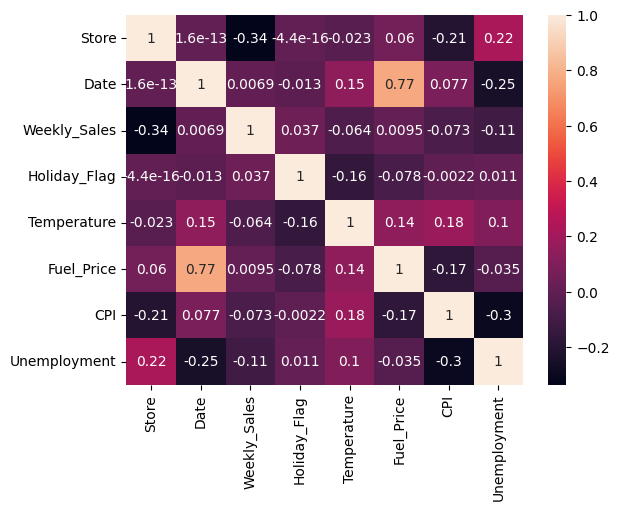

In [55]:
#check correlation
sns.heatmap(walmart.corr(), annot=True)

<Axes: xlabel='Date'>

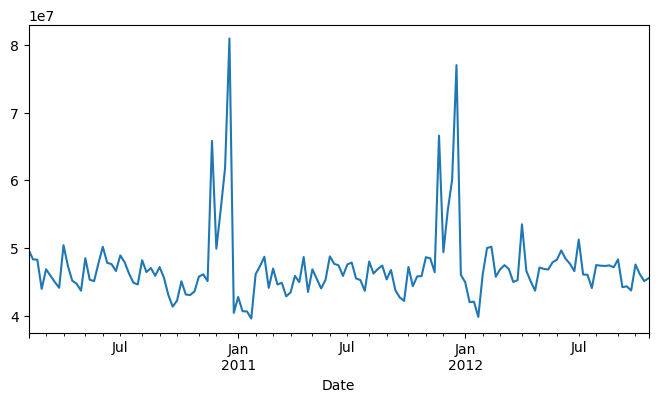

In [56]:
#group the sum of weekly sales by date
walmart.groupby('Date')['Weekly_Sales'].sum().plot(figsize=(8, 4))


In [57]:
#extract year, month and week from the Date column and assign a new column to each in our walmart dataframe

walmart['Year'] = walmart['Date'].dt.year
walmart['Month'] = walmart['Date'].dt.month
walmart['Week'] = walmart['Date'].dt.isocalendar().week

In [58]:
#sorting data by store and date
walmart = walmart.sort_values(['Store', 'Date'])

walmart

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,9,39
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,40
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,41
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,42


In [59]:
# creating a lag feature and a rolling 4 day average feature from weekly sales

walmart['weekly sales lag'] = walmart.groupby('Store')['Weekly_Sales'].shift(1)

walmart

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,weekly sales lag
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,1643690.90
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,1641957.44
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,1611968.17
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,1409727.59
...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,9,39,723086.20
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,40,713173.95
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,41,733455.07
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,42,734464.36


In [60]:
walmart['Weekly_Sales_Rolling4'] = walmart.groupby('Store')['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(4).mean())
walmart

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,weekly sales lag,Weekly_Sales_Rolling4
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,NaN,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,1643690.90,NaN
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,1641957.44,NaN
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,1611968.17,NaN
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,1409727.59,1.576836e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,9,39,723086.20,7.315338e+05
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,40,713173.95,7.262528e+05
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,41,733455.07,7.179884e+05
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,42,734464.36,7.260449e+05


In [61]:
#creating lag features naturally introduces null values, we can drop null values because they are only a few
df_model = walmart.dropna(subset=['weekly sales lag', 'Weekly_Sales_Rolling4'])
#we can now drop the date column as well
df_model.drop(columns= ['Date'])

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,weekly sales lag,Weekly_Sales_Rolling4
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,1409727.59,1.576836e+06
5,1,1439541.59,0,57.79,2.667,211.380643,8.106,2010,3,10,1554806.68,1.554615e+06
6,1,1472515.79,0,54.58,2.720,211.215635,8.106,2010,3,11,1439541.59,1.504011e+06
7,1,1404429.92,0,51.45,2.732,211.018042,8.106,2010,3,12,1472515.79,1.469148e+06
8,1,1594968.28,0,62.27,2.719,210.820450,7.808,2010,4,13,1404429.92,1.467823e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,2012,9,39,723086.20,7.315338e+05
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,40,713173.95,7.262528e+05
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,41,733455.07,7.179884e+05
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,42,734464.36,7.260449e+05


In [62]:
# Feature columns
features = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'weekly sales lag', 'Weekly_Sales_Rolling4']

X = df_model[features]

#target
y = df_model['Weekly_Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


In [63]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 39017.41
RMSE: 58480.82
MAPE: 5.42%


Given the quantum of weekly sales which is in millions the model being 58k off on average is quite decent.

*Cross-validate*

In [64]:


# Initialize the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)

# Perform cross-validation (use negative MAE as the metric)
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Convert negative scores to positive (since scoring returns negative values for MAE)
print(f"Cross-validated MAE: {-np.mean(scores):.2f}")



Cross-validated MAE: 53488.01


*MAE seems off on cross validation*

*Hyperparameter Tuning*

In [65]:
# Define the model
model = XGBRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {-grid_search.best_score_:.2f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Score: 61452.43


In [66]:
# Define the model
model = XGBRegressor()

# Define hyperparameters for random search
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': [3, 4, 5],
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   scoring='neg_mean_absolute_error', n_iter=50, cv=3,
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {-random_search.best_score_:.2f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': np.float64(0.9616794696232923), 'learning_rate': np.float64(0.10138413075201119), 'max_depth': 3, 'n_estimators': 200, 'subsample': np.float64(0.9368466053024315)}
Best Score: 60884.98


In [67]:
best_params = grid_search.best_params_  # Or random_search.best_params_

# Initialize the final model with the best hyperparameters
final_model = XGBRegressor(**best_params)

# Train the model on the entire training set
final_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_final = final_model.predict(X_test)

# Calculate MAE, RMSE, and MAPE
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mape_final = np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100

print(f"Final MAE: {mae_final:.2f}")
print(f"Final RMSE: {rmse_final:.2f}")
print(f"Final MAPE: {mape_final:.2f}%")


Final MAE: 38388.56
Final RMSE: 58318.11
Final MAPE: 5.47%


In [68]:
best_params = random_search.best_params_

# Initialize the final model with the best hyperparameters
final_model = XGBRegressor(**best_params)

# Train the model on the entire training set
final_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_final = final_model.predict(X_test)

# Calculate MAE, RMSE, and MAPE
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mape_final = np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100

print(f"Final MAE: {mae_final:.2f}")
print(f"Final RMSE: {rmse_final:.2f}")
print(f"Final MAPE: {mape_final:.2f}%")

Final MAE: 39582.86
Final RMSE: 59532.77
Final MAPE: 5.63%


*I think we can stick to our original model in this case*

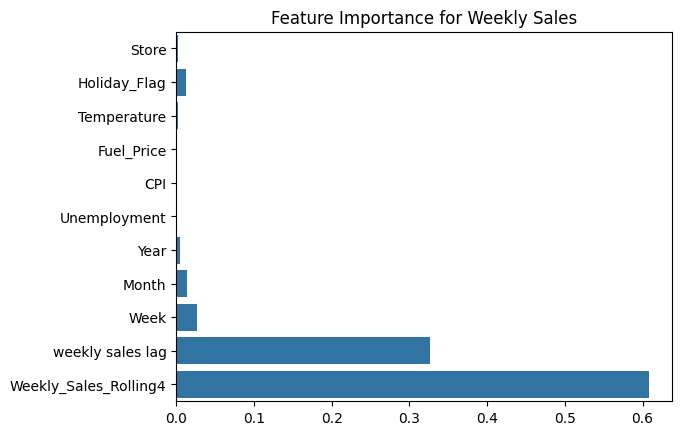

In [69]:
#Let's plot feature importance

feature_importance = final_model.feature_importances_
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance for Weekly Sales")
plt.show()


In [70]:
#Holiday flag being a int representation of a categorical variable, we will need to conduct t-test to confirm it's effect on weekly sales

from scipy.stats import ttest_ind

holiday_sales = walmart[walmart['Holiday_Flag'] == 1]['Weekly_Sales']
non_holiday_sales = walmart[walmart['Holiday_Flag'] == 0]['Weekly_Sales']

t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales)
print(f"T-stat: {t_stat}, P-value: {p_value}")

T-stat: 2.9608919093259036, P-value: 0.003078699263818616


with p-value being lower than 0.05, and t-stat being positive, it seems that holiday does have a significant positive impact on weekly sales, that means people shop more on holidays

**Project 2 : Online Retail Customer Segmentation**

In [71]:
#read the data and take a quick glance
retail = pd.read_csv('/content/OnlineRetail (3).csv', encoding='ISO-8859-1')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [72]:
#remove negative quantities which are returned products
retail = retail[retail['Quantity'] > 0]

In [73]:
#chekc which items are sold in largest quantities
retail.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,78033
WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047
JUMBO BAG RED RETROSPOT,48478
WHITE HANGING HEART T-LIGHT HOLDER,37895
POPCORN HOLDER,36761
ASSORTED COLOUR BIRD ORNAMENT,36461
PACK OF 72 RETROSPOT CAKE CASES,36419
RABBIT NIGHT LIGHT,30788


In [74]:
retail.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [75]:
#Convert date column to proper data format and extract month from it

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail['Month'] = retail['InvoiceDate'].dt.to_period('M')

retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12


<Axes: xlabel='Month'>

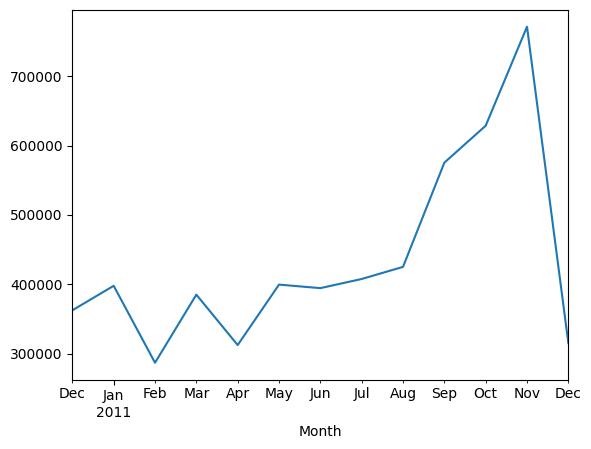

In [76]:
#plot a linechart of monthly sales in terms of total quantity
monthly_sales = retail.groupby('Month')['Quantity'].sum()
monthly_sales.plot()

In [77]:
#country wise performance
retail['TotalPrice'] = retail['Quantity'] * retail['UnitPrice']
country_sales = retail.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

In [78]:
#now aggregate data by grouping customers to view -- 1.how recent their purchases were 2. how many unique purchases they made
#and 3.what was the total monetary value of all those

import datetime as dt

# Reference date
ref_date = retail['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM table
rfm = retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})


In [79]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [80]:
##Now we can cluster the customers based on their recency, frequency and monetary values

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [81]:
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,15.672986,22.047393,12453.225924
1,248.564030,1.551789,478.107581
2,7.384615,82.692308,127338.313846
3,43.910580,3.655748,1349.698298
